# Interacting with fission product yields in ENDF-6 format (MF=8, MT=454/459)

First let's import `sandy` and the other python packages for formatting and postprocessing that are used in this notebook.

In [1]:
import yaml
import urllib
import os

import pandas as pd

In [2]:
%%capture --no-stdout
import sandy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")

%matplotlib inline

## Parsing the data in ENDF-6 format

The first thing that we want to do with an evaluated nuclear data  file in ENDF-6 format is to load its content into python using `sandy`.
By calling `sandy.Endf6.from_file`, the ENDF-6 file is parsed and its content is split into text sections, each of them indexed by a unique combination of MAT, MF and MT numbers. 

Below we report an example using the JEFF-3.3 fission yield evaluated file available on the [OECD/NEA website](https://www.oecd-nea.org/dbdata/jeff/jeff33/index.html).
The file content is loaded into the `Endf6` instance that we name `tape`.

In [4]:
url = "https://www.oecd-nea.org/dbdata/jeff/jeff33/downloads/JEFF33-nfy.asc"
with urllib.request.urlopen(url) as f:
    text_fy = f.read().decode('utf-8')

In [5]:
%%capture
tape = sandy.Endf6.from_text(text_fy)

In [6]:
tape

MAT   MF  MT 
9040  1   451     9.023200+4 2.300450+2         -1          1  ...
      8   454     9.023200+4 2.300450+2          2          0  ...
          459     9.023200+4 2.300450+2          2          0  ...
9222  1   451     9.223300+4 2.310380+2         -1          1  ...
      8   454     9.223300+4 2.310380+2          3          0  ...
          459     9.223300+4 2.310380+2          3          0  ...
9225  1   451     9.223400+4 2.320300+2         -1          1  ...
      8   454     9.223400+4 2.320300+2          1          0  ...
          459     9.223400+4 2.320300+2          1          0  ...
9228  1   451     9.223500+4 2.330250+2         -1          1  ...
      8   454     9.223500+4 2.330250+2          3          0  ...
          459     9.223500+4 2.330250+2          3          0  ...
9231  1   451     9.223600+4 2.340180+2         -1          1  ...
      8   454     9.223600+4 2.340180+2          2          0  ...
          459     9.223600+4 2.340180+2         

Now, the information available in each `(MAT,MF,MT)` section in ASCII format can be extracted using method `.read_section`, 
as shown below.

> Recall that MF=8 MT=454 are the indices for independent fission yields, MF=8 MT=459 for cumulative fission yields

In [7]:
mat = 9437  # This is Pu-239
mf = 8
mt = 454

section = tape.read_section(mat, mf, mt)

For a better visualization of the FY data structure generated by `.read_section` we resort to the `yaml` package and we print only the first 11 lines.

In [8]:
print("\n".join(yaml.dump(section).splitlines()[:11]))

AWR: 236.999
E:
  0.0253:
    INTERP: 1
    ZAP:
      10010:
        DFY: 7.052699999999999e-06
        FY: 4.08e-05
      10020:
        DFY: 2.8929000000000003e-06
        FY: 1.347e-05


The data contained in the ENDF-6 section are stored in nested dictionaries, 
according to the following structure that tries and replicate the ENDF-6 hierarchy.

```yaml
    AWR : atomic weight ratio
    E :   # dictionary of tabulated energies at which fission yields are given
        energy :  # energy of the neutron causing fission (eV)
            INTERP : interpolation scheme between this and the following energy point
            ZAP :   # dictionary of fission products
                Z*1000 + A*10 + M :
                    FY : fission yield (fraction)
                    DFY : uncertainty on fission yield (same unit as FY)
                Z2*1000 + A2*10 + M2 : ...
        energy_2 : ...
```

## Create a `sandy.Fy` object

Class `sandy.Fy` was developed to store and process fission yield data.

The ASCII content in a `sandy.Endf6` instance can be directly imported into a `sandy.Fy` instance using 
classmethod `.from_endf6`, where the `sandy.Endf6` object is passed as an argument.

In [9]:
fy = sandy.Fy.from_endf6(tape)
fy

        MAT   MT     ZAM     ZAP           E          FY
0      9040  454  902320   10010 4.00000e+05 1.60730e-05
1      9040  454  902320   10020 4.00000e+05 4.91210e-06
2      9040  454  902320   10030 4.00000e+05 7.00810e-05
3      9040  454  902320   20030 4.00000e+05 0.00000e+00
4      9040  454  902320   20040 4.00000e+05 1.01610e-03
...     ...  ...     ...     ...         ...         ...
79489  9640  459  962450  781960 4.00000e+05 5.24140e-12
79490  9640  459  962450  781970 4.00000e+05 3.23410e-12
79491  9640  459  962450  781971 4.00000e+05 2.43890e-12
79492  9640  459  962450  781980 4.00000e+05 1.51570e-12
79493  9640  459  962450  791970 4.00000e+05 3.31460e-12

[79494 rows x 6 columns]

The `pd.DataFrame` containing the source data is stored in attribute `.data`, which contains fission yields FY together with the corresponding:
- MAT
- MT
- ZAM
- ZAP
- E

Here ZAM and ZAP are the `Z*10000 + A*10 + M` representation for the parent and daugther nuclides.

## How to filter the fission yield data 

The fission yield data can be filtered directly applying the `pandas` functionality to attribute `.data`.
However, we recommend using method `.filter_by` to make sure that the returned object be still a `sandy.Fy` instance.

Below are two examples where `sandy.Fy` instances are created first by filtering only the cumulative yield at thermal energy for the fission of U-235 (`ZAM=922350`), and then keeping only the cumulative fission yields at thermal energy for Cs-137 (`ZAP=551370`) independently of the fissioning nuclide.

In [10]:
cfyU235 = fy.filter_by("ZAM", 922350).filter_by("MT", 459).filter_by("E", 2.53e-2)
cfyU235

      MAT   MT     ZAM     ZAP           E          FY
0    9228  459  922350   10010 2.53000e-02 1.71100e-05
1    9228  459  922350   10020 2.53000e-02 8.40000e-06
2    9228  459  922350   10030 2.53000e-02 1.08000e-04
3    9228  459  922350   20030 2.53000e-02 1.08000e-04
4    9228  459  922350   20040 2.53000e-02 1.70210e-03
..    ...  ...     ...     ...         ...         ...
978  9228  459  922350  701770 2.53000e-02 1.08900e-12
979  9228  459  922350  701771 2.53000e-02 1.08900e-12
980  9228  459  922350  711750 2.53000e-02 7.36160e-12
981  9228  459  922350  711770 2.53000e-02 1.08900e-12
982  9228  459  922350  721770 2.53000e-02 1.08900e-12

[983 rows x 6 columns]

In [11]:
cfyCs137 = fy.filter_by("ZAP", 551370).filter_by("MT", 459).filter_by("E", 2.53e-2)
cfyCs137

     MAT   MT     ZAM     ZAP           E          FY
0   9222  459  922330  551370 2.53000e-02 6.26070e-02
1   9228  459  922350  551370 2.53000e-02 6.08970e-02
2   9231  459  922360  551370 2.53000e-02 6.08310e-02
3   9346  459  932370  551370 2.53000e-02 7.03340e-02
4   9349  459  932380  551370 2.53000e-02 7.09050e-02
5   9434  459  942380  551370 2.53000e-02 5.84950e-02
6   9437  459  942390  551370 2.53000e-02 6.57960e-02
7   9443  459  942410  551370 2.53000e-02 6.40440e-02
8   9543  459  952410  551370 2.53000e-02 7.20690e-02
9   9547  459  952420  551370 2.53000e-02 5.65360e-02
10  9549  459  952430  551370 2.53000e-02 7.31680e-02
11  9634  459  962430  551370 2.53000e-02 7.03410e-02
12  9637  459  962440  551370 2.53000e-02 6.88910e-02
13  9640  459  962450  551370 2.53000e-02 5.37540e-02

## Plotting

Plotting fission yields as a function of mass or charge can be cumbersome with the current information available in a `sandy.Fy` instance.
In fact, to do so columns ZAM or ZAP should be *expanded* to their source components Z, A, M, where Z is the charge number, A is the number of nucleons and M is the metastate number.

Here we introduce two new methods that do exactly what required: `._expand_zap` and `._expand_zam`.

The first method returns a copy a of the `.data` attribute with three extra columns: the Z, A and M of the fission product.
The second method returns a copy a of the `.data` attribute with three extra columns: the Z, A and M of the fissioning nuclide.

> Methods `._expand_zap` and `._expand_zam` return a `pd.DataFrame` and not a `sandy.Fy` instance.

In [12]:
cfyU235._expand_zap().head()

,MAT,MT,ZAM,ZAP,E,FY,Z,A,M
0,9228,459,922350,10010,2.53000e-02,1.71100e-05,1,1,0
1,9228,459,922350,10020,2.53000e-02,8.40000e-06,1,2,0
2,9228,459,922350,10030,2.53000e-02,1.08000e-04,1,3,0
3,9228,459,922350,20030,2.53000e-02,1.08000e-04,2,3,0
4,9228,459,922350,20040,2.53000e-02,1.70210e-03,2,4,0


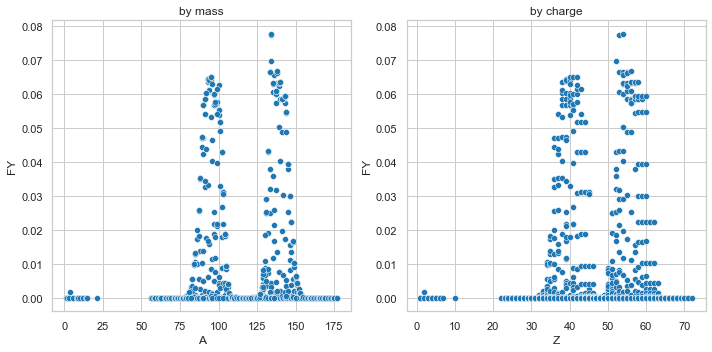

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0] = sns.scatterplot(x="A", y="FY", data=cfyU235._expand_zap(), ax=ax[0])
ax[1] = sns.scatterplot(x="Z", y="FY", data=cfyU235._expand_zap(), ax=ax[1])

ax[0].set_title("by mass")
ax[1].set_title("by charge")

plt.tight_layout();

In [14]:
cfyCs137._expand_zam().head()

,MAT,MT,ZAM,ZAP,E,FY,Z,A,M
0,9222,459,922330,551370,2.53000e-02,6.26070e-02,92,233,0
1,9228,459,922350,551370,2.53000e-02,6.08970e-02,92,235,0
2,9231,459,922360,551370,2.53000e-02,6.08310e-02,92,236,0
3,9346,459,932370,551370,2.53000e-02,7.03340e-02,93,237,0
4,9349,459,932380,551370,2.53000e-02,7.09050e-02,93,238,0


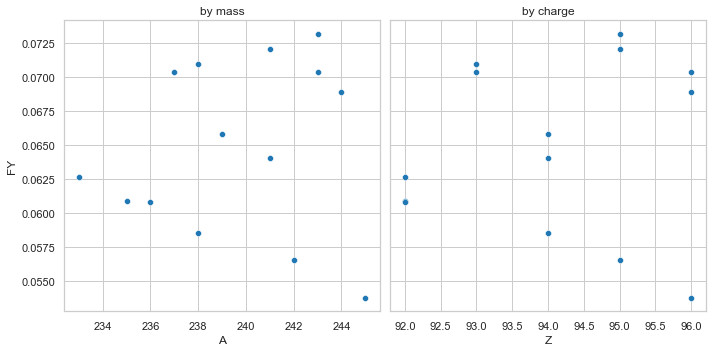

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax[0] = sns.scatterplot(x="A", y="FY", data=cfyCs137._expand_zam(), ax=ax[0])
ax[0].set_title("by mass")

ax[1] = sns.scatterplot(x="Z", y="FY", data=cfyCs137._expand_zam(), ax=ax[1])
ax[1].set_title("by charge")

plt.tight_layout();

## Tabulated fission yields as a function of energy

It is sometimes important to have access to the fission yield data (either cumulaitve or independent, not both) as a tabulated function of energy.
This can be done by calling method `.energy_table` where the fissioning nuclide is specified as an argument either as a ZAM or MAT number. 

Below we report an example for the cumulative yields of U-235.

In [16]:
fy.energy_table(922350, by="ZAM", kind="cumulative")

ZAP,10010,10020,10030,20030,20040,20060,30060,30080,30090,40080,...,761940,761950,771910,771911,771930,771940,771950,771951,781940,781950
E,,,,,,,,,,,,,,,,,,,,,
2.53000e-02,1.71100e-05,8.40000e-06,1.08000e-04,1.08000e-04,1.70210e-03,2.66800e-05,2.66800e-05,7.29200e-07,4.07100e-07,1.34180e-06,...,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
4.00000e+05,2.68910e-05,8.21820e-06,1.08000e-04,1.08000e-04,1.70000e-03,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,...,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
1.40000e+07,2.63690e-05,8.05870e-06,1.74200e-04,1.74200e-04,1.66700e-03,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,...,3.31630e-12,1.04300e-12,1.94260e-11,9.16910e-12,6.63920e-12,3.31630e-12,1.40570e-12,1.35380e-12,3.31630e-12,2.69180e-12


## Write to HDF5 file

Codes like ALEPH read fission yields from nuclear data files in HDF5 format.
To produce such files we can use `sandy` and method `Fy.to_hdf5`, which extracts and stores energy tables for each set of fission yields found in the `Fy` object.

As an example, we can transfer the whole content of the `fy` instance to a HDF5 file `'fy.hdf5'`.

In [17]:
file = 'fy.hdf5'
if os.path.exists(file):
    os.remove(file)
fy.to_hdf5(file, "jeff_33");

The group key for each set of fission yields is `"library/fy/kind/zam"`, where
- library: is the lowercase name of the library
- fy: is the key "fy"
- kind: is either "independent" or "cumulative"
- zam: is the ZAM number of the parent nuclide

> The energy values in the HDF5 file are converted into MeV.

In [18]:
pd.read_hdf(file, key='jeff_33/fy/cumulative/922380')

ZAP,10010,10020,10030,20030,20040,190500,190510,200500,200510,200520,...,761930,761940,761950,771910,771911,771930,771940,771950,781940,781950
E,,,,,,,,,,,,,,,,,,,,,
4.00000e-01,2.35370e-05,7.19320e-06,1.02620e-04,1.02620e-04,1.48800e-03,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,...,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
1.40000e+01,1.30120e-05,3.97660e-06,6.49900e-05,6.49900e-05,8.22600e-04,2.14670e-12,1.16000e-12,2.85210e-11,2.28820e-11,2.47380e-11,...,3.79010e-12,2.95410e-12,1.00010e-12,1.31880e-11,6.22490e-12,3.79010e-12,2.95410e-12,1.00010e-12,2.95410e-12,1.00010e-12


## Apply custom perturbations

to be written